# COMP579 Assignment 3

**Value-based methods with linear function approximation [40 points]**

In [1]:
import os
import random
import gymnasium as gym
import numpy as np
import pandas as pd

from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
from itertools import product
from tqdm.auto import tqdm
import seaborn as sns

import multiprocessing as mp

In [2]:
# Helper functions
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])


def softmax(x, temp=1.0):
    """
    Compute the softmax of each element along an axis of X with temperature adjustment.
    When temp is 0, the function returns an argmax-like result.

    Parameters:
    x (array_like): Input data.
    temp (float, optional): Temperature parameter to adjust the sharpness of softmax. Default is 1.0.

    Returns:
    array_like: Softmax-transformed output with the same shape as input x.
    """
    if temp == 0:
        # Simulate argmax behavior for zero temperature
        return np.equal(x, np.max(x, axis=-1, keepdims=True)).astype(float)
    else:
        # Adjust for temperature and improve numerical stability in one step
        z = (x - np.max(x, axis=-1, keepdims=True)) / temp
        top = np.exp(z)
        bottom = np.sum(top, axis=-1, keepdims=True)
        return top / bottom

### Q Learner and Expected SARSA
Implement Q-learning and Expected SARSA for both `MountainCar-v0` and `CartPole-v1` environments from the Gym suite using the following guidelines:

- Use a linear function approximation for $Q$, that is, if $x$ is a vector representing the state and $\theta$ a is the action vector, use $$Q(x, a) = \sum^{d}_{i=1} θ_{a,i} x_i$$ where $\theta$ are the parameters of the $Q$-function you
need to learn, $d$ is the dimension of $x$ and $a \in \{1, \cdots , m\}$ is a discrete action.

In [3]:
class QLearner:
    """
    A class representing the Q-learning algorithm.

    Attributes:
    env (gym.Env): The environment to interact with.
    alpha (float): The learning rate.
    gamma (float): The discount factor for future rewards.
    Q (numpy.ndarray): The Q-table for storing state-action values.

    Methods:
    select_action(s, greedy=False): Selects an action based on the current policy.
    update(s, a, r, s_prime, a_prime, done): Updates the Q-table based on the observed transition.
    """

    def __init__(self, env, alpha, gamma, epsilon, input_size, action_size):
        """
        Initializes the Q-learning agent.

        Parameters:
            env (gym.Env): The environment to interact with.
            alpha (float): The learning rate.
            gamma (float): The discount factor for future rewards.
            epsilon (float): The exploration rate for epsilon-greedy action selection.
            input_size (int): The size of the input space
            action_size (int): The size of the action space
        """
        self.env = env
        self.input_size = input_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Initialize Q-values uniformly between -0.001 and 0.001
        self.theta = np.random.uniform(-0.001, 0.001, (input_size, action_size))

    def select_action(self, s, greedy=False):
        """
        Selects an action based on the current policy using epsilon-greedy method.

        Parameters:
            s (int): The current state.
            greedy (bool): If True, overrides epsilon-greedy and selects the action with the highest Q-value.

        Returns:
            int: The selected action.
        """
        if greedy or np.random.rand() < self.epsilon:
            # With probability epsilon, choose a random allowed action
            return np.random.choice(list(range(self.action_size)))
        else:
            # Otherwise, choose the action with the highest estimated Q-value among the allowed actions
            Q_values = np.dot(s, self.theta)
            return np.argmax(Q_values)

    def update(self, s, a, r, s_prime, done):
        """
        Updates the Q-table based on the observed transition using the Q-learning update rule.

        Parameters:
            s (int): The current state.
            a (int): The action taken.
            r (float): The reward received.
            s_prime (int): The next state.
            done (bool): Whether the episode has ended.
        """
        # Compute the current estimate of Q(s, a)
        current_Q = np.dot(s, self.theta[:, a])

        # Best future Q-value for the next state
        Q_prime = 0 if done else np.max(np.dot(s_prime, self.theta[:, a]))

        # Compute the TD error
        td_error = r + self.gamma * Q_prime - current_Q

        # Update the weights for the taken action a
        self.theta[:, a] += self.alpha * td_error * s


## Mountain Car

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. This version is the one with discrete actions.

This MDP first appeared in Andrew Moore’s PhD Thesis (1990)

|  |  |
| ---- | ---- |
| Action space | `Discrete(3)` |
| Observation Space | `Box([-1.2 -0.07], [0.6 0.07], (2,), float32)` |
| Import | `gymnasium.make("MountainCar-v0")` |

### Observation Space

The observation is a ndarray with shape `(2,)` where the elements correspond to the following:

| Num | Observation                               | Min   | Max  | Unit           |
|-----|-------------------------------------------|-------|------|----------------|
| 0   | position of the car along the x-axis      | -1.2  | 0.6  | position (m)   |
| 1   | velocity of the car                       | -0.07 | 0.07 | velocity (v)   |

### Action Space

There are 3 discrete deterministic actions:

- 0: Accelerate to the left
- 1: Don’t accelerate
- 2: Accelerate to the right

### Transition Dynamics:

Given an action, the mountain car follows the following transition dynamics:

`velocity_{t+1} = velocity_t + (action - 1) * force - cos(3 * position_t) * gravity`

`position_{t+1} = position_t + velocity_{t+1}`

where `force = 0.001` and `gravity = 0.0025`. The collisions at either end are inelastic with the velocity set to 0 upon collision with the wall. The position is clipped to the range `[-1.2, 0.6]` and velocity is clipped to the range `[-0.07, 0.07]`.

### Reward:

The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of -1 for each timestep.

### Starting State

The position of the car is assigned a uniform random value in `[-0.6 , -0.4]`. The starting velocity of the car is always assigned to 0.

### Episode End

The episode ends if either of the following happens:

- Termination: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
- Truncation: The length of the episode is 200.


In [4]:
mc_env = gym.make("MountainCar-v0")

In [5]:
s, info = mc_env.reset()

### Tile-coding
- Discretise the state space for both the environments using an appropriate tile-coding (see section 9.5.4 of the RL book http://incompleteideas.net/book/RLbook2020.pdf for how to do tilecoding).
- It is generally recommended to use at most 10 tiles (bins) per state variable, but you are free to choose more tiles if it results in better performance.
- It is easier to imagine tiling each dimension of the state-space independently, in that case, one tiling of $s_2$, for example, is just one way to make bins out of $s_2$.
- So suppose the state-space is 2D so we have the state is $s = (s_1 , s_2)$.
- Suppose we have 2 tilings of 5 tiles (bins) each per dimension of $s$, idea is to convert the state representation from $s$ to the $2*2*5=20$ dim vector:
$$x = (x_{1,1,1} , x_{1,1,2} , \ldots , x_{1,1,5} , x_{1,2,1}, \ldots , x_{1,2,5} , x_{2,1,1} , x_{2,1,2} , \ldots , x_{2,1,5} , x_{2,2,1} , \ldots , x_{2,2,5}),$$
which contains only 1s and 0s where $x_{i,j,k} = 1$ iff $s_i$ is in tile $k$ of the $j$-th tiling (of the $i$-th state dimension), and 0 otherwise.

In [24]:
class TileCoder:
    def __init__(self, x_min, x_max, v_min, v_max, x_bins, v_bins, num_frames):
        self.x_min = x_min
        self.x_max = x_max
        self.v_min = v_min
        self.v_max = v_max
        self.x_bins = x_bins
        self.v_bins = v_bins
        self.num_frames = num_frames

        # Calculate the size of a single bin across each dimension
        self.x_unit_size = (x_max - x_min) / x_bins
        self.v_unit_size = (v_max - v_min) / v_bins

        # Generate the base frames
        self.x_frames = [np.linspace(x_min, x_max, x_bins + 1) + self.x_unit_size * (i - num_frames) / num_frames for i in range(num_frames * 2)]
        self.v_frames = [np.linspace(v_min, v_max, v_bins + 1) + self.v_unit_size * (i - num_frames) / num_frames for i in range(num_frames * 2)]

    def get_active_tiles(self, x, v):
        tol = 1e-4
        assert x >= self.x_min-tol and x <= self.x_max+tol, f"x={x} is not in range [{self.x_min}, {self.x_max}]"
        assert v >= self.v_min-tol and v <= self.v_max+tol, f"v={v} is not in range [{self.v_min}, {self.v_max}]"
        x_frame_indices = [np.searchsorted(frame, x) for frame in self.x_frames]
        v_frame_indices = [np.searchsorted(frame, v) for frame in self.v_frames]
        
        x_one_hot_frames = np.array([
            one_hot(index, self.v_bins+2)[1:-1]  # we +2 to add an index for the left and right and then remove it with [1:-1]
            for index in x_frame_indices
        ])
        v_one_hot_frames = np.array([
            one_hot(index, self.v_bins+2)[1:-1]  # we +2 to add an index for the left and right and then remove it with [1:-1]
            for index in v_frame_indices
        ])
        return x_one_hot_frames.flatten()

    def plot_frames(self):
        plt.figure(figsize=(8, 6))
        colors = plt.cm.viridis(np.linspace(0, 1, len(self.x_frames)))  # Using a colormap

        for i, frame in enumerate(zip(self.x_frames, self.v_frames)):
            x_frame, v_frame = frame
            X, V = np.meshgrid(x_frame, v_frame)
            plt.plot(X, V, 'o-', color=colors[i % len(self.x_frames)], markersize=2, linewidth=1, alpha=0.7)
            plt.plot(X.T, V.T, 'o-', color=colors[i % len(self.x_frames)], markersize=2, linewidth=1, alpha=0.7)

        # Drawing the boundary in red
        plt.plot([self.x_min, self.x_max, self.x_max, self.x_min, self.x_min], [self.v_min, self.v_min, self.v_max, self.v_max, self.v_min], 'r-', linewidth=2)

        plt.title('Tile-coding plot')
        plt.xlabel('Position (x)')
        plt.ylabel('Velocity (v)')
        plt.grid(True)
        plt.show()

# Example usage:
tile_coder = TileCoder(
    x_min = -1.2,
    x_max = 0.6,
    v_min = -0.07,
    v_max = 0.07,
    x_bins = 4,
    v_bins = 6,
    num_frames = 3
)

In [25]:
input_size = tile_coder.get_active_tiles(0.1, 0.04).shape[0]
input_size

36

### Plot the Tile-coding

We plot the tile-coding we generated to check that we got it right

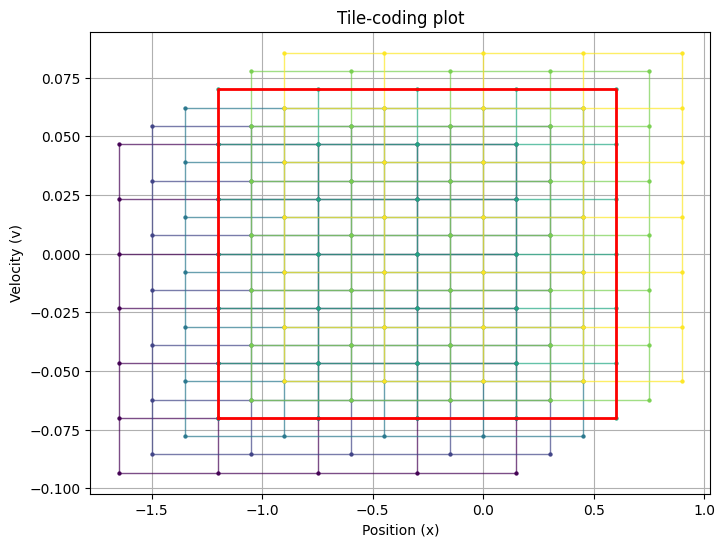

In [27]:
tile_coder.plot_frames()

### Hyperparameters
- Initalise the parameters for the value function uniformly between −0.001 and 
0.001.
- Use an $\varepsilon$-greedy policy with three choices of $\varepsilon$ and step-size parameters 1/4, 1/8, 1/16 and
run 50 learning trials with different initialisations for $Q$, each having 1000 episodes, for each
configuration. (That means 3 configs * 50 runs * 1000 episodes).


In [28]:
models = [QLearner(mc_env, alpha=0.1, gamma=0.9, epsilon=eps, input_size=input_size, action_size=3) for eps in [1/4, 1/8, 1/16]]

In [29]:
def run_trial(env, model, tile_coder, n_episodes=1000):
    train_history = []

    for episode in tqdm(range(n_episodes)):
        s, info = env.reset()
        s = tile_coder.get_active_tiles(*s)
        done = False
        total_reward = 0
        segment = 0

        while not done and segment < 200:
            a = model.select_action(s)
            s_prime, r, done, trunc, info = env.step(a)
            s_prime = tile_coder.get_active_tiles(*s_prime)
            model.update(s, a, r, s_prime, done)
            s = s_prime
            total_reward += r
            segment += 1

        train_history.append({
            'model_name': 'Q-Learning',
            'episode': episode,
            'num_segments': segment,
            'total_reward': total_reward,
            'alpha': model.alpha,
            'gamma': model.gamma,
            'epsilon': model.epsilon
        })

    return model, pd.DataFrame(train_history)


(array([4., 4., 2., 6., 3., 2., 3., 2., 3., 4., 2., 1., 2., 2., 4., 6., 4.,
        5., 5., 5., 2., 5., 4., 2., 7., 4., 3., 5., 2., 5.]),
 array([-9.99373615e-04, -9.33914309e-04, -8.68455004e-04, -8.02995698e-04,
        -7.37536392e-04, -6.72077087e-04, -6.06617781e-04, -5.41158475e-04,
        -4.75699170e-04, -4.10239864e-04, -3.44780558e-04, -2.79321253e-04,
        -2.13861947e-04, -1.48402641e-04, -8.29433355e-05, -1.74840298e-05,
         4.79752759e-05,  1.13434582e-04,  1.78893887e-04,  2.44353193e-04,
         3.09812499e-04,  3.75271804e-04,  4.40731110e-04,  5.06190416e-04,
         5.71649721e-04,  6.37109027e-04,  7.02568333e-04,  7.68027638e-04,
         8.33486944e-04,  8.98946250e-04,  9.64405555e-04]),
 <BarContainer object of 30 artists>)

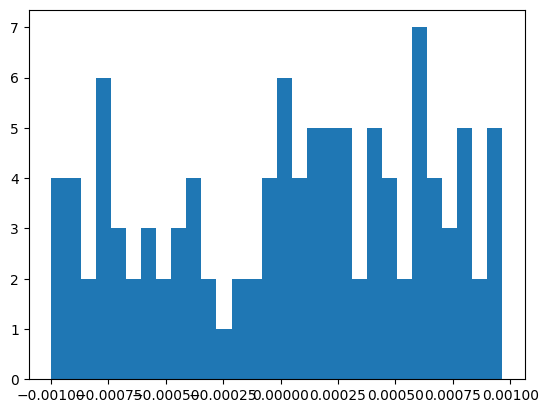

In [36]:
model = QLearner(mc_env, alpha=0.01, gamma=0.9, epsilon=0.1, input_size=input_size, action_size=3)
plt.hist(model.theta.flatten(), bins=30)

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([18., 10.,  7.,  7.,  0.,  1.,  1.,  5.,  2., 57.]),
 array([-1.98217597e+00, -1.78386383e+00, -1.58555169e+00, -1.38723954e+00,
        -1.18892740e+00, -9.90615260e-01, -7.92303118e-01, -5.93990976e-01,
        -3.95678834e-01, -1.97366692e-01,  9.45449512e-04]),
 <BarContainer object of 10 artists>)

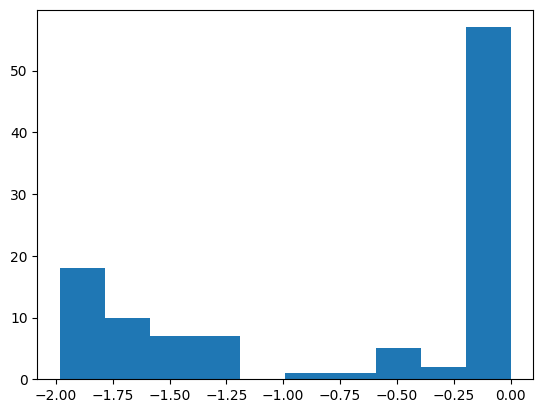

In [37]:
trained_model, trial_history = run_trial(
    mc_env, 
    model, 
    tile_coder, 
    n_episodes=1000
)

plt.hist(trained_model.theta.flatten())

<Axes: xlabel='episode'>

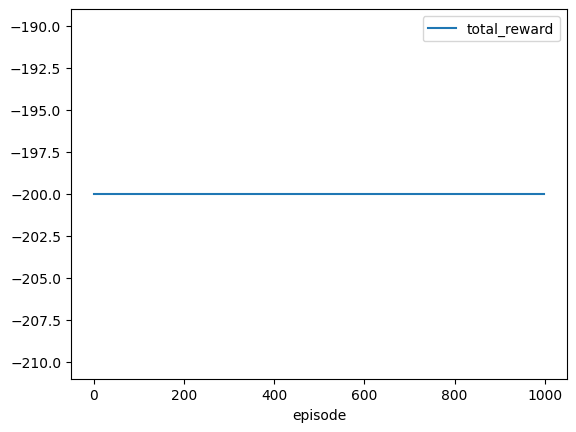

In [38]:
trial_history.plot(kind='line', x='episode', y='total_reward')

### Plots
- Plot the average performance of the policy on the Y-axis and the number of episodes on the
X-axis. The plots should also include the interquantile range of the 50 independent runs. Note
that you are expected to plot 9 results corresponding to each ϵ and step-size parameters for
both the environments, and document your findings in a separate pdf along with the results.
Explain why one algorithm performs better than the other or why a particular configuration
results in better performance.

### Rules
- Implement all the methods without using any automatic differentiation package. It is highly recommended that you undertake the development of software independently. Furthermore, it is essential to appropriately cite any resources or materials sourced from the
internet in your work.

# Write your experiment code below

In [7]:
! rm -rf data/*.csv

In [ ]:
%%time
if not os.path.exists('data/train_df.csv') or not os.path.exists('data/test_df.csv'):
    train_df, test_df = run_parallel_trials(trial_params)
    train_df.to_csv('data/train_df.csv', index=False)
    test_df.to_csv('data/test_df.csv', index=False)
else:
    train_df = pd.read_csv('data/train_df.csv')
    test_df = pd.read_csv('data/test_df.csv')

  0%|          | 0/1280 [00:00<?, ?it/s]

In [ ]:
train_df

In [ ]:
test_df

In [ ]:
good_runs = train_df[train_df.step == train_df.step.max()].sort_values("return", ascending=False).head(10).run.values

In [ ]:
es_df = train_df[train_df.trial < 1]

# Assuming `df` is your DataFrame with the data provided
# Here we group by 'run' and then plot each group
groups = es_df.groupby(['run', 'trial'])

plt.figure(figsize=(15, 10))  # Set the figure size as desired

for name, group in groups:
    model_name, alpha, temp, trial = group.reset_index(drop=True).loc[0,['model_name', 'alpha', 'temp', 'trial']].values
    label = f'model={model_name}, alpha={alpha:.2f}, temp={temp:.2f}'
    plt.plot(group['step'], group['return'], marker='o', linestyle='-', label=label)

plt.xlabel('Step Number')
plt.ylabel('Return')
plt.title('Return over Steps Grouped by Run Number')
plt.legend(title='Run Number')
plt.show()

In [ ]:
es_df = test_df[test_df.trial < 1]

# Assuming `df` is your DataFrame with the data provided
# Here we group by 'run' and then plot each group
groups = es_df.groupby(['run', 'trial'])

plt.figure(figsize=(15, 10))  # Set the figure size as desired

for name, group in groups:
    model_name, alpha, temp, trial = group.reset_index(drop=True).loc[0,['model_name', 'alpha', 'temp', 'trial']].values
    label = f'model={model_name}, alpha={alpha:.2f}, temp={temp:.2f}'
    plt.plot(group['step'], group['return'], marker='o', linestyle='-', label=label)

plt.xlabel('Step Number')
plt.ylabel('Return')
plt.title('Return over Steps Grouped by Run Number')
plt.legend(title='Run Number')
plt.show()

## The graphs

### Graph 1

One graph that shows the effect of the parameters on the final **training** performance.

The x-axis shows the different parameters (e.g. learning rate), and the y-axis shows the return
of the agent (averaged over the last 10 training episodes and the 10 runs); note that this will
typically end up as an upside-down U.
    
**For each algorithm**, the graph should have at least 3 lines (e.g. 3 temperature values) corre-
sponding to the choices of the other hyperparameter. There should be at least 6 lines in the
graph, and at least 18 different points. Also plot the uncertainty using shading (e.g. using the
min and the max return of the 10 runs)

In [ ]:
# Assuming `df` is your DataFrame
# Step 1: Filter to only include the last 10 training episodes of each segment
df_training_last_10 = train_df[(train_df['episode'] > n_episodes - 11) & (train_df['segment'] == n_segments-1)]

# Step 2: Group by model, hyperparameters, and segment, then calculate mean return for the last 10 episodes
grouped_means = df_training_last_10.groupby(['model_name', 'alpha', 'temp', 'run', 'trial', 'segment'])['return'].mean().reset_index()

# Step 3: Further aggregate across trials to get the mean, min, and max returns for each hyperparameter combination
final_stats = grouped_means.groupby(['model_name', 'alpha', 'temp']).agg(
    mean_return=('return', 'mean'),
    min_return=('return', 'min'),
    max_return=('return', 'max')
).reset_index()

# Setup the figure and axes for a 2x2 grid of plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 14), sharey=True)

# Titles for each column (Sarsa vs Expected Sarsa)
column_titles = {'sarsa': 'Sarsa', 'expected_sarsa': 'Expected Sarsa'}
# Titles for the rows based on the x-axis variable
row_titles = ['Alpha', 'Temperature']

# Assuming final_stats is correctly structured and contains 'model_name' column with 'Sarsa' and 'Expected Sarsa'
for col_index, model in enumerate(column_titles):
    model_data = final_stats[final_stats['model_name'] == model]

    # First row plots: Alpha values
    unique_alphas = model_data['alpha'].unique()
    for alpha in unique_alphas:
        subset_alpha = model_data[model_data['alpha'] == alpha].sort_values(by='temp')
        if not subset_alpha.empty:  # Check if subset is not empty
            axes[0, col_index].plot(subset_alpha['temp'], subset_alpha['mean_return'], label=f'Alpha={alpha:.2f}', marker='o')
            axes[0, col_index].fill_between(subset_alpha['temp'], subset_alpha['min_return'], subset_alpha['max_return'], alpha=0.2)
    axes[0, col_index].set_title(column_titles[model])
    axes[0, col_index].set_xlabel('Temperature')
    axes[0, col_index].set_ylabel('Average Return')
    axes[0, col_index].legend(title='Learning Rate (alpha)')
    axes[0, col_index].grid(True)

    # Second row plots: Temperature values
    unique_temps = model_data['temp'].unique()
    for temp in unique_temps:
        subset_temp = model_data[model_data['temp'] == temp].sort_values(by='alpha')
        if not subset_temp.empty:  # Check if subset is not empty
            axes[1, col_index].plot(subset_temp['alpha'], subset_temp['mean_return'], label=f'Temp={temp:.2f}', marker='o')
            axes[1, col_index].fill_between(subset_temp['alpha'], subset_temp['min_return'], subset_temp['max_return'], alpha=0.2)
    axes[1, col_index].set_xlabel('Learning Rate (alpha)')
    axes[1, col_index].set_ylabel('Average Return')
    axes[1, col_index].legend(title='Temperature')
    axes[1, col_index].grid(True)

plt.tight_layout()
plt.show()

## Graph 2: Test performance

The same graph that instead shows the effect of the parameters on the final testing performance. The y-axis should now show the return during the final testing episode, averaged over the 10 runs.

In [ ]:
# Assuming `df` is your DataFrame
# Step 1: Filter to only include the last 10 training episodes of each segment
df_test_last_10 = test_df.loc[test_df.segment == n_segments - 1, :]

# Step 2: Group by model, hyperparameters, and segment, then calculate mean return for the last 10 episodes
grouped_means = df_test_last_10.groupby(['model_name', 'alpha', 'temp', 'run', 'trial', 'segment'])['return'].mean().reset_index()

# Step 3: Further aggregate across trials to get the mean, min, and max returns for each hyperparameter combination
final_stats = grouped_means.groupby(['model_name', 'alpha', 'temp']).agg(
    mean_return=('return', 'mean'),
    min_return=('return', 'min'),
    max_return=('return', 'max')
).reset_index()

# Setup the figure and axes for a 2x2 grid of plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 14), sharey=True)

# Titles for each column (Sarsa vs Expected Sarsa)
column_titles = {'sarsa': 'Sarsa', 'expected_sarsa': 'Expected Sarsa'}
# Titles for the rows based on the x-axis variable
row_titles = ['Alpha', 'Temperature']

# Assuming final_stats is correctly structured and contains 'model_name' column with 'Sarsa' and 'Expected Sarsa'
for col_index, model in enumerate(column_titles):
    model_data = final_stats[final_stats['model_name'] == model]

    # First row plots: Alpha values
    unique_alphas = model_data['alpha'].unique()
    for alpha in unique_alphas:
        subset_alpha = model_data[model_data['alpha'] == alpha].sort_values(by='temp')
        if not subset_alpha.empty:  # Check if subset is not empty
            axes[0, col_index].plot(subset_alpha['temp'], subset_alpha['mean_return'], label=f'Alpha={alpha:.2f}', marker='o')
            axes[0, col_index].fill_between(subset_alpha['temp'], subset_alpha['min_return'], subset_alpha['max_return'], alpha=0.2)
    axes[0, col_index].set_title(column_titles[model])
    axes[0, col_index].set_xlabel('Temperature')
    axes[0, col_index].set_ylabel('Average Return')
    axes[0, col_index].legend(title='Learning Rate (alpha)')
    axes[0, col_index].grid(True)

    # Second row plots: Temperature values
    unique_temps = model_data['temp'].unique()
    for temp in unique_temps:
        subset_temp = model_data[model_data['temp'] == temp].sort_values(by='alpha')
        if not subset_temp.empty:  # Check if subset is not empty
            axes[1, col_index].plot(subset_temp['alpha'], subset_temp['mean_return'], label=f'Temp={temp:.2f}', marker='o')
            axes[1, col_index].fill_between(subset_temp['alpha'], subset_temp['min_return'], subset_temp['max_return'], alpha=0.2)
    axes[1, col_index].set_xlabel('Learning Rate (alpha)')
    axes[1, col_index].set_ylabel('Average Return')
    axes[1, col_index].legend(title='Temperature')
    axes[1, col_index].grid(True)

plt.tight_layout()
plt.show()

## Graph 3: Learning curves

Learning curves (mean and standard deviation computed based on the 10 runs) for the best
parameter setting for each algorithm. X-axis shows the segment, Y-axis shows return over-
time.